In [1]:
import pandas as pd

# 전처리 CSV 파일 불러오기 
df = pd.read_csv('wildfire_preprocessed_4_logs_target.csv')

# 데이터 첫 5행 확인
print(df.head())

   DSPT_REQ_HR  HR_UNIT_ARTMP  HR_UNIT_HUM  WSPD_BIN  MONTH  \
0          246           -1.0         39.0         1      1   
1          253            5.0         60.0         1      3   
2          643            7.0         49.0         1      3   
3          578            0.3         48.0         3      3   
4          874           -8.7         36.0         5     12   

   CMBS_EXPOBJ_LCLSF_NM_가연성가스  CMBS_EXPOBJ_LCLSF_NM_기타  \
0                           0                        0   
1                           0                        0   
2                           0                        0   
3                           0                        0   
4                           0                        0   

   CMBS_EXPOBJ_LCLSF_NM_미상  CMBS_EXPOBJ_LCLSF_NM_쓰레기류  \
0                        0                          0   
1                        0                          0   
2                        0                          0   
3                        0                  

In [2]:
df.head()

,DSPT_REQ_HR,HR_UNIT_ARTMP,HR_UNIT_HUM,WSPD_BIN,MONTH,CMBS_EXPOBJ_LCLSF_NM_가연성가스,CMBS_EXPOBJ_LCLSF_NM_기타,CMBS_EXPOBJ_LCLSF_NM_미상,CMBS_EXPOBJ_LCLSF_NM_쓰레기류,CMBS_EXPOBJ_LCLSF_NM_위험물등,...,WNDRCT_BRNG_남서,WNDRCT_BRNG_동,WNDRCT_BRNG_북,WNDRCT_BRNG_북동,WNDRCT_BRNG_북서,WNDRCT_BRNG_서,ARRIVAL_DELAY_MIN_LOG,CNTR_GRNDS_DSTNC_LOG,FRSTN_GRNDS_DSTNC_LOG,FIRE_SUPESN_HR_LOG
0,246,-1.0,39.0,1,1,0,0,0,0,0,...,0,0,0,0,1,0,3.044522,1.609438,2.484907,7.090910
1,253,5.0,60.0,1,3,0,0,0,0,0,...,1,0,0,0,0,0,2.397895,1.098612,1.609438,6.398595
2,643,7.0,49.0,1,3,0,0,0,0,0,...,1,0,0,0,0,0,3.230145,1.791759,2.302585,7.284821
3,578,0.3,48.0,3,3,0,0,0,0,0,...,0,0,0,0,1,0,3.276516,1.098612,1.791759,7.333023
4,874,-8.7,36.0,5,12,0,0,0,0,0,...,0,0,0,0,0,1,4.852551,2.397895,3.295837,9.579487


In [4]:
! pip install xgboost


Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 30.9 MB/s  0:00:00


In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xgboost as xgb
from xgboost import XGBRegressor  # ← LGBMRegressor 대신

from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [4]:
# 파일 경로
CSV_PATH = "wildfire_preprocessed_4_logs_target.csv"

# 예측 시점 선택에 따라 누수 변수 포함/제외 토글
# True  -> 도착 이후 시점(허용),  ARRIVAL_DELAY_MIN_LOG 포함
# False -> 발생 직후 시점(비허용), ARRIVAL_DELAY_MIN_LOG 제외
INCLUDE_LEAKY = True

# 데이터 로드
df = pd.read_csv(CSV_PATH)

print(f"행: {len(df):,}, 열: {len(df.columns)}")
print("\n컬럼명:\n", df.columns.tolist()[:50], " ...")
display(df.head())

# 타깃/피처 선택
TARGET = "FIRE_SUPESN_HR_LOG"
if TARGET not in df.columns:
    raise ValueError(f"'{TARGET}' 컬럼이 없습니다.")

# 숫자형 컬럼만 사용(원-핫 완료 가정)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [c for c in numeric_cols if c != TARGET]

# 필요 시 누수 변수 제거
if not INCLUDE_LEAKY and "ARRIVAL_DELAY_MIN_LOG" in feature_cols:
    feature_cols.remove("ARRIVAL_DELAY_MIN_LOG")

X = df[feature_cols].copy()
y = df[TARGET].copy()

# 결측치 처리(있으면 행 제거)
mask = ~(X.isnull().any(axis=1) | y.isnull())
X = X[mask]
y = y[mask]

print(f"\n최종 데이터 크기: X={X.shape}, y={y.shape}")
print(f"누수 변수 포함 여부(INCLUDE_LEAKY) = {INCLUDE_LEAKY}")

행: 3,359, 열: 62

컬럼명:
 ['DSPT_REQ_HR', 'HR_UNIT_ARTMP', 'HR_UNIT_HUM', 'WSPD_BIN', 'MONTH', 'CMBS_EXPOBJ_LCLSF_NM_가연성가스', 'CMBS_EXPOBJ_LCLSF_NM_기타', 'CMBS_EXPOBJ_LCLSF_NM_미상', 'CMBS_EXPOBJ_LCLSF_NM_쓰레기류', 'CMBS_EXPOBJ_LCLSF_NM_위험물등', 'CMBS_EXPOBJ_LCLSF_NM_자동차,철도차량,선박,항공기', 'CMBS_EXPOBJ_LCLSF_NM_전기,전자', 'CMBS_EXPOBJ_LCLSF_NM_종이,목재,건초등', 'CMBS_EXPOBJ_LCLSF_NM_침구,직물류', 'CMBS_EXPOBJ_LCLSF_NM_합성수지', 'CMBS_EXPOBJ_LCLSF_NM_nan', 'IGTN_HTSRC_NM_기타(발화원인)', 'IGTN_HTSRC_NM_담뱃불, 라이터불', 'IGTN_HTSRC_NM_마찰, 전도, 복사', 'IGTN_HTSRC_NM_미상(발화원인)', 'IGTN_HTSRC_NM_불꽃, 불티', 'IGTN_HTSRC_NM_자연적 발화열', 'IGTN_HTSRC_NM_작동기기', 'IGTN_HTSRC_NM_폭발물, 폭죽', 'IGTN_HTSRC_NM_화학적 발화열', 'CTPV_NM_강원특별자치도', 'CTPV_NM_경기도', 'CTPV_NM_경상남도', 'CTPV_NM_경상북도', 'CTPV_NM_광주광역시', 'CTPV_NM_대구광역시', 'CTPV_NM_대전광역시', 'CTPV_NM_부산광역시', 'CTPV_NM_서울특별시', 'CTPV_NM_세종특별자치시', 'CTPV_NM_울산광역시', 'CTPV_NM_인천광역시', 'CTPV_NM_전라남도', 'CTPV_NM_전북특별자치도', 'CTPV_NM_제주특별자치도', 'CTPV_NM_충청남도', 'CTPV_NM_충청북도', 'FND_IGTN_PSTN_NM_미상', 'FND_IGTN_PSTN_NM_산아래', 'FND_IGTN

,DSPT_REQ_HR,HR_UNIT_ARTMP,HR_UNIT_HUM,WSPD_BIN,MONTH,CMBS_EXPOBJ_LCLSF_NM_가연성가스,CMBS_EXPOBJ_LCLSF_NM_기타,CMBS_EXPOBJ_LCLSF_NM_미상,CMBS_EXPOBJ_LCLSF_NM_쓰레기류,CMBS_EXPOBJ_LCLSF_NM_위험물등,...,WNDRCT_BRNG_남서,WNDRCT_BRNG_동,WNDRCT_BRNG_북,WNDRCT_BRNG_북동,WNDRCT_BRNG_북서,WNDRCT_BRNG_서,ARRIVAL_DELAY_MIN_LOG,CNTR_GRNDS_DSTNC_LOG,FRSTN_GRNDS_DSTNC_LOG,FIRE_SUPESN_HR_LOG
0,246,-1.0,39.0,1,1,0,0,0,0,0,...,0,0,0,0,1,0,3.044522,1.609438,2.484907,7.090910
1,253,5.0,60.0,1,3,0,0,0,0,0,...,1,0,0,0,0,0,2.397895,1.098612,1.609438,6.398595
2,643,7.0,49.0,1,3,0,0,0,0,0,...,1,0,0,0,0,0,3.230145,1.791759,2.302585,7.284821
3,578,0.3,48.0,3,3,0,0,0,0,0,...,0,0,0,0,1,0,3.276516,1.098612,1.791759,7.333023
4,874,-8.7,36.0,5,12,0,0,0,0,0,...,0,0,0,0,0,1,4.852551,2.397895,3.295837,9.579487



최종 데이터 크기: X=(3359, 61), y=(3359,)
누수 변수 포함 여부(INCLUDE_LEAKY) = True


In [5]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, KFold
import numpy as np

def optimize_hyperparameters(X, y):
    """
    XGBoost 핵심+추가 하이퍼파라미터 (5-fold, MSE 기준)
    - 탐색 파라미터: n_estimators, learning_rate, max_depth, min_child_weight,
                    subsample, colsample_bytree, reg_alpha, reg_lambda
    - 조합 수: 256개 (실행시간 과하지 않게 조정)
    """
    print("=== 1단계: XGBoost 하이퍼파라미터 최적화 시작 ===")

    # 모델 정의
    xgbm = XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1,
        tree_method="hist"   # 빠른 학습
    )

    # 확대된 그리드(적당한 크기)
    param_grid = {
        "n_estimators": [300, 600],          # 부스팅 라운드 수
        "learning_rate": [0.05, 0.1],        # 학습률
        "max_depth": [4, 6],                 # 트리 깊이
        "min_child_weight": [1, 3],          # 리프 최소 가중치
        "subsample": [0.8, 1.0],             # row sampling
        "colsample_bytree": [0.8, 1.0],      # feature sampling
        "reg_alpha": [0.0, 0.1],             # L1 규제
        "reg_lambda": [1.0, 2.0],            # L2 규제
    }

    # 교차검증 설정
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # 그리드 서치
    gscv = GridSearchCV(
        estimator=xgbm,
        param_grid=param_grid,
        cv=cv,
        scoring="neg_mean_squared_error",  # MSE 기준
        n_jobs=-1,
        verbose=1,
        refit=True
    )
    gscv.fit(X, y)

    # 결과
    best_params = gscv.best_params_
    best_score_mse = -gscv.best_score_

    print(f"\n최적 하이퍼파라미터: {best_params}")
    print(f"최적 CV MSE: {best_score_mse:,.4f} (RMSE={np.sqrt(best_score_mse):,.4f})")

    return best_params, gscv.best_estimator_

# 실행 예시
best_params, best_model = optimize_hyperparameters(X.values, y)


=== 1단계: XGBoost 하이퍼파라미터 최적화 시작 ===
Fitting 5 folds for each of 256 candidates, totalling 1280 fits

최적 하이퍼파라미터: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 300, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 1.0}
최적 CV MSE: 0.5316 (RMSE=0.7291)


최적 하이퍼파라미터: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 300, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 1.0}
최적 CV MSE: 0.5316 (RMSE=0.7291)

In [6]:
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score
import numpy as np

def train_multiple_models(X, y, best_params, n_iterations=10, k_folds=5):
    """
    XGBoost: 최적 파라미터 고정 + seed만 바꿔가며 다회 k-fold CV
    RMSE / MAE / R² 평균·표준편차 저장
    """
    print(f"\n=== 2단계: {n_iterations}회 학습(k={k_folds}) ===")
    results = []
    models = []

    # numpy 배열로 통일(경고 방지 및 일관성)
    X_np = np.asarray(X)
    y_np = np.asarray(y)

    for i in range(n_iterations):
        print(f"\n--- {i+1}번째 모델 학습 ---")
        xgbm = XGBRegressor(
            **best_params,
            random_state=42 + i,
            n_jobs=-1,
            tree_method="hist"   # CPU 학습 가속(가능 시)
        )
        kf = KFold(n_splits=k_folds, shuffle=True, random_state=42 + i)

        # MSE / R2 / MAE (neg_* → 부호 반전)
        mse_scores = -cross_val_score(
            xgbm, X_np, y_np, cv=kf,
            scoring='neg_mean_squared_error', n_jobs=-1
        )
        rmse_scores = np.sqrt(mse_scores)

        r2_scores  = cross_val_score(
            xgbm, X_np, y_np, cv=kf,
            scoring='r2', n_jobs=-1
        )
        mae_scores = -cross_val_score(
            xgbm, X_np, y_np, cv=kf,
            scoring='neg_mean_absolute_error', n_jobs=-1
        )

        result = {
            'iteration': i+1,
            'mse_mean': mse_scores.mean(), 'mse_std': mse_scores.std(),
            'rmse_mean': rmse_scores.mean(), 'rmse_std': rmse_scores.std(),
            'r2_mean': r2_scores.mean(),     'r2_std': r2_scores.std(),
            'mae_mean': mae_scores.mean(),   'mae_std': mae_scores.std(),
            'mse_scores': mse_scores, 'rmse_scores': rmse_scores,
            'r2_scores': r2_scores,   'mae_scores': mae_scores
        }
        results.append(result)
        models.append(xgbm)

        print(f"  RMSE: {rmse_scores.mean():.4f} ± {rmse_scores.std():.4f}")
        print(f"  MAE : {mae_scores.mean():.4f} ± {mae_scores.std():.4f}")
        print(f"  R²  : {r2_scores.mean():.4f} ± {r2_scores.std():.4f}")

    return results, models

# 실행 예시
results, models = train_multiple_models(X.values, y, best_params, n_iterations=10, k_folds=5)



=== 2단계: 10회 학습(k=5) ===

--- 1번째 모델 학습 ---
  RMSE: 0.7290 ± 0.0140
  MAE : 0.4445 ± 0.0043
  R²  : 0.7422 ± 0.0248

--- 2번째 모델 학습 ---
  RMSE: 0.7381 ± 0.0623
  MAE : 0.4484 ± 0.0283
  R²  : 0.7367 ± 0.0210

--- 3번째 모델 학습 ---
  RMSE: 0.7423 ± 0.0826
  MAE : 0.4501 ± 0.0192
  R²  : 0.7294 ± 0.0647

--- 4번째 모델 학습 ---
  RMSE: 0.7404 ± 0.0230
  MAE : 0.4506 ± 0.0132
  R²  : 0.7316 ± 0.0411

--- 5번째 모델 학습 ---
  RMSE: 0.7663 ± 0.0837
  MAE : 0.4537 ± 0.0147
  R²  : 0.7152 ± 0.0485

--- 6번째 모델 학습 ---
  RMSE: 0.7349 ± 0.0382
  MAE : 0.4489 ± 0.0127
  R²  : 0.7376 ± 0.0255

--- 7번째 모델 학습 ---
  RMSE: 0.7086 ± 0.0567
  MAE : 0.4432 ± 0.0115
  R²  : 0.7580 ± 0.0240

--- 8번째 모델 학습 ---
  RMSE: 0.7318 ± 0.0524
  MAE : 0.4468 ± 0.0157
  R²  : 0.7393 ± 0.0404

--- 9번째 모델 학습 ---
  RMSE: 0.7248 ± 0.0467
  MAE : 0.4443 ± 0.0226
  R²  : 0.7400 ± 0.0526

--- 10번째 모델 학습 ---
  RMSE: 0.7567 ± 0.0655
  MAE : 0.4516 ± 0.0234
  R²  : 0.7224 ± 0.0419



=== 3단계: XGBoost 결과 종합 및 분석 ===

전체 10개 모델 성능 요약:
RMSE 평균: 0.7373 ± 0.0153
MAE  평균: 0.4482 ± 0.0033
R²   평균: 0.7352 ± 0.0111

최고 R² 모델: 7번째 (R²=0.7580)
최저 MSE 모델: 7번째 (MSE=0.5053, RMSE=0.7109)


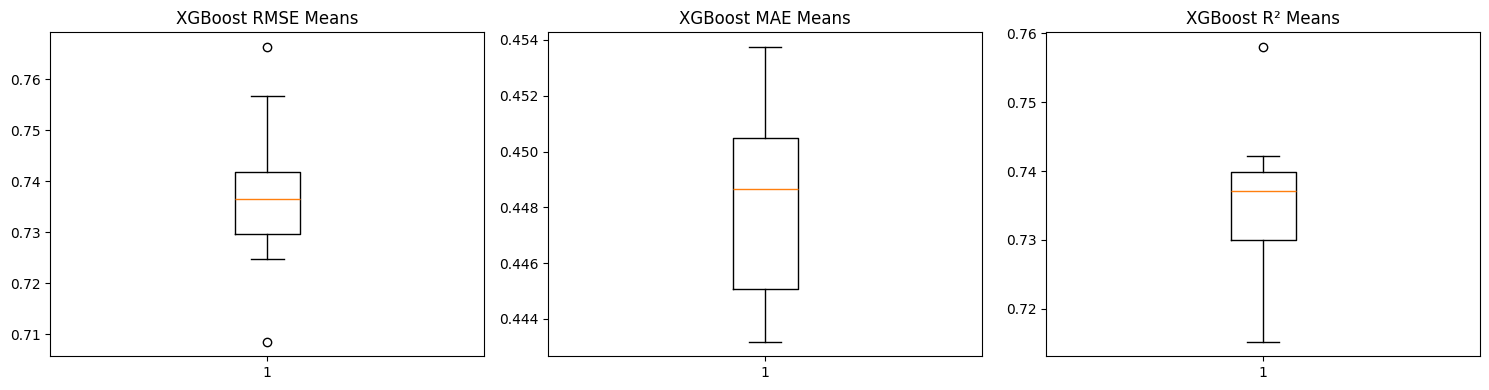

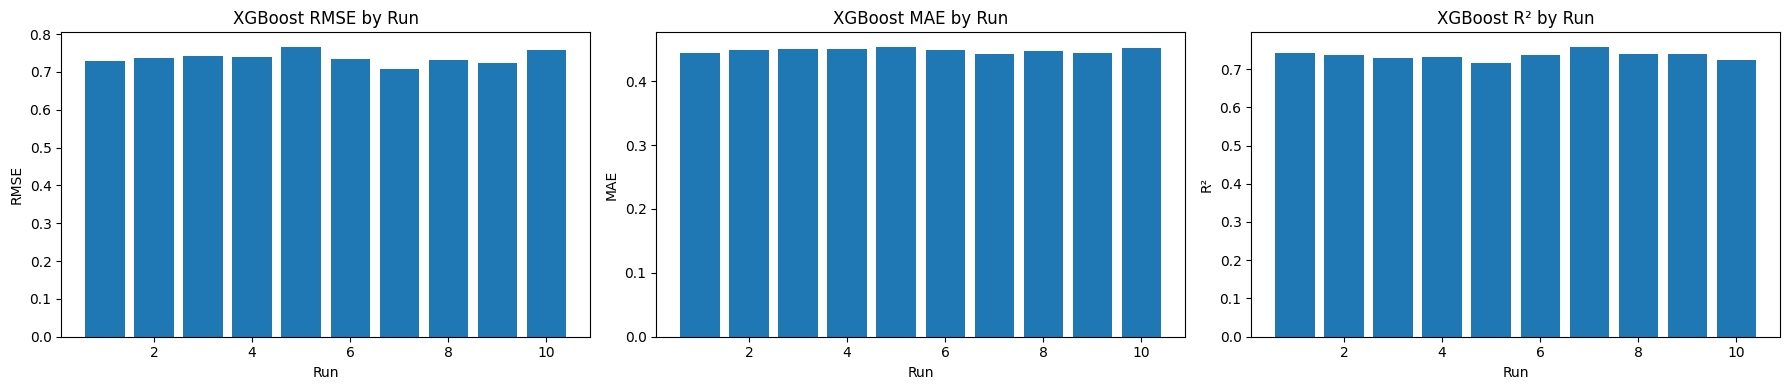


성능 지표 간 상관계수:
          MSE    RMSE     MAE      R2
MSE   1.0000  0.9964  0.9406 -0.9802
RMSE  0.9964  1.0000  0.9414 -0.9849
MAE   0.9406  0.9414  1.0000 -0.9241
R2   -0.9802 -0.9849 -0.9241  1.0000


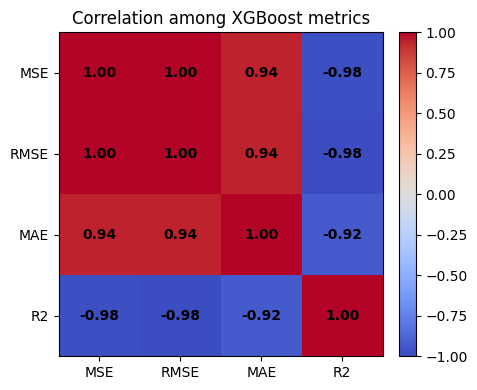

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def analyze_results(results):
    print("\n=== 3단계: XGBoost 결과 종합 및 분석 ===")
    rmse_means = [r['rmse_mean'] for r in results]
    mae_means  = [r['mae_mean']  for r in results]
    r2_means   = [r['r2_mean']   for r in results]
    mse_means  = [r['mse_mean']  for r in results]

    print(f"\n전체 {len(results)}개 모델 성능 요약:")
    print(f"RMSE 평균: {np.mean(rmse_means):.4f} ± {np.std(rmse_means):.4f}")
    print(f"MAE  평균: {np.mean(mae_means):.4f} ± {np.std(mae_means):.4f}")
    print(f"R²   평균: {np.mean(r2_means):.4f} ± {np.std(r2_means):.4f}")

    best_r2_idx  = int(np.argmax(r2_means))
    best_mse_idx = int(np.argmin(mse_means))
    print(f"\n최고 R² 모델: {best_r2_idx+1}번째 (R²={r2_means[best_r2_idx]:.4f})")
    print(f"최저 MSE 모델: {best_mse_idx+1}번째 (MSE={mse_means[best_mse_idx]:.4f}, RMSE={np.sqrt(mse_means[best_mse_idx]):.4f})")

    # --- Boxplot (분포)
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    axes[0].boxplot(rmse_means); axes[0].set_title('XGBoost RMSE Means')
    axes[1].boxplot(mae_means);  axes[1].set_title('XGBoost MAE Means')
    axes[2].boxplot(r2_means);   axes[2].set_title('XGBoost R² Means')
    plt.tight_layout(); plt.show()

    # --- Bar plot (비교)
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    axes[0].bar(range(1, len(results)+1), rmse_means); axes[0].set_title('XGBoost RMSE by Run'); axes[0].set_xlabel('Run'); axes[0].set_ylabel('RMSE')
    axes[1].bar(range(1, len(results)+1), mae_means);  axes[1].set_title('XGBoost MAE by Run');  axes[1].set_xlabel('Run'); axes[1].set_ylabel('MAE')
    axes[2].bar(range(1, len(results)+1), r2_means);   axes[2].set_title('XGBoost R² by Run');   axes[2].set_xlabel('Run'); axes[2].set_ylabel('R²')
    plt.tight_layout(); plt.show()

    # --- 상관행렬
    corr_df = pd.DataFrame({
        'MSE': mse_means, 'RMSE': rmse_means, 'MAE': mae_means, 'R2': r2_means
    })
    corr = corr_df.corr()
    print("\n성능 지표 간 상관계수:\n", corr.round(4))

    plt.figure(figsize=(5,4))
    im = plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(corr.columns)), corr.columns)
    plt.yticks(range(len(corr.columns)), corr.columns)
    for i in range(len(corr.columns)):
        for j in range(len(corr.columns)):
            plt.text(j, i, f'{corr.iloc[i, j]:.2f}', ha='center', va='center',
                     color='black', fontweight='bold')
    plt.title('Correlation among XGBoost metrics')
    plt.tight_layout(); plt.show()

    return best_r2_idx, best_mse_idx

# 사용 예시 (XGBoost로 계산한 results 전달)
best_r2_idx, best_mse_idx = analyze_results(results)


In [8]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform

# OS별 한글 폰트 설정
if platform.system() == 'Darwin':  # Mac
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  # Windows
    plt.rc('font', family='Malgun Gothic')
else:  # Linux (예: Colab)
    plt.rc('font', family='NanumGothic')

plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지



=== XGBoost 특성 중요도 분석 ===

상위 10개 특성 중요도:


,feature,importance
58,ARRIVAL_DELAY_MIN_LOG,0.248833
26,CTPV_NM_경기도,0.049299
59,CNTR_GRNDS_DSTNC_LOG,0.046721
29,CTPV_NM_광주광역시,0.045485
12,"CMBS_EXPOBJ_LCLSF_NM_종이,목재,건초등",0.034246
53,WNDRCT_BRNG_동,0.029619
15,CMBS_EXPOBJ_LCLSF_NM_nan,0.028584
35,CTPV_NM_울산광역시,0.026903
43,FND_IGTN_PSTN_NM_산아래,0.025229
23,"IGTN_HTSRC_NM_폭발물, 폭죽",0.025119


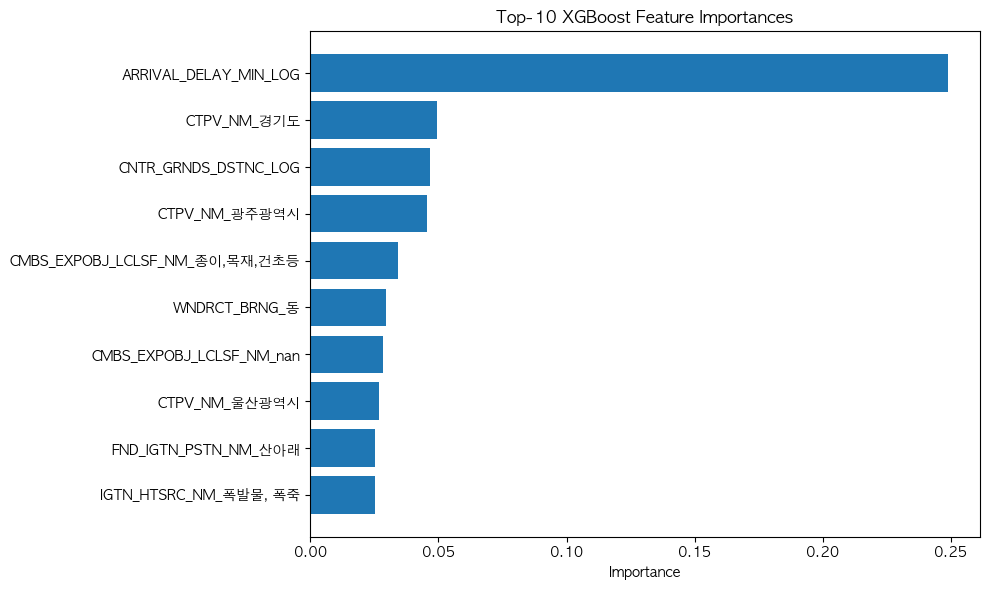

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

print("\n=== XGBoost 특성 중요도 분석 ===")

# 1) feature 목록 (X가 DataFrame이라고 가정)
feature_cols = list(X.columns)

# 2) 최적 모델(best_model)이 XGBRegressor가 아니라면 여기서 정의/적합
#    이미 외부에서 학습된 XGBRegressor가 best_model에 있다면 다음 두 줄은 생략 가능
# best_model = XGBRegressor(random_state=42, n_estimators=600, learning_rate=0.05)
# best_model.fit(X, y)

# 3) 중요도 계산 (기본은 'gain' 기준)
fi = pd.DataFrame({
    'feature': feature_cols,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

# 4) 상위 10개 출력
print("\n상위 10개 특성 중요도:")
display(fi.head(10))

# 5) 시각화
plt.figure(figsize=(10, 6))
top = fi.head(10)
plt.barh(range(len(top)), top['importance'])
plt.yticks(range(len(top)), top['feature'])
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.title('Top-10 XGBoost Feature Importances')
plt.tight_layout()
plt.show()


In [10]:
# === K-fold CV + 평균 종속변수 시간 계산 (로그/원단위 모두) — 출력 단위: 분/시간 선택 ===
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

# -----------------------
# 설정
# -----------------------
TARGET_IS_LOG = True        # 타깃이 로그변환 컬럼이면 True
TIME_UNIT     = "min"       # 출력 단위: 'sec' | 'min' | 'hour'
SHOW_BOTH     = True        # True면 보조 단위도 함께 표시

# 최적 하이퍼파라미터 (XGBoost)
xgb_params = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.05,
    'max_depth': 4,
    'min_child_weight': 1,
    'n_estimators': 300,
    'reg_alpha': 0.0,
    'reg_lambda': 1.0,
    'subsample': 1.0,
    'random_state': 42,
    'n_jobs': -1,
    'tree_method': 'hist'   # CPU 가속 (GPU면 'gpu_hist')
}

assert 'X' in globals() and 'y' in globals(), "먼저 X, y를 준비하세요."

X_np = np.asarray(X)                      # DataFrame이면 values로 변환됨
y_np = np.asarray(y, dtype=float)

# -----------------------
# 헬퍼
# -----------------------
def to_unit(v_sec, unit="sec"):
    if unit == "min":  return v_sec / 60.0
    if unit == "hour": return v_sec / 3600.0
    return v_sec

def unit_label(unit):
    return {"sec":"초", "min":"분", "hour":"시간"}[unit]

def hhmm(v_sec):
    v_sec = float(v_sec)
    h = int(v_sec // 3600)
    m = int((v_sec % 3600) // 60)
    return f"{h}h {m}m"

def show_with_both(name, v_sec):
    main_val = to_unit(v_sec, TIME_UNIT)
    s = f"{name}: {main_val:,.2f} {unit_label(TIME_UNIT)}"
    if SHOW_BOTH:
        other_unit = {"sec":"min", "min":"hour", "hour":"min"}[TIME_UNIT]
        other_val  = to_unit(v_sec, other_unit)
        s += f"  |  ({other_val:,.2f} {unit_label(other_unit)}, ~{hhmm(v_sec)})"
    return s

# -----------------------
# K-fold CV (로그 스케일 성능)
# -----------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)

y_true_list_log, y_pred_list_log = [], []
rmse_list_log, mae_list_log, r2_list_log = [], [], []

for fold_idx, (tr, va) in enumerate(kf.split(X_np), start=1):
    X_tr, X_va = X_np[tr], X_np[va]
    y_tr, y_va = y_np[tr], y_np[va]

    model = XGBRegressor(objective="reg:squarederror", **xgb_params)
    model.fit(X_tr, y_tr)
    y_va_pred = model.predict(X_va)

    rmse_log = np.sqrt(mean_squared_error(y_va, y_va_pred))
    mae_log  = mean_absolute_error(y_va, y_va_pred)
    r2_log   = r2_score(y_va, y_va_pred)

    rmse_list_log.append(rmse_log)
    mae_list_log.append(mae_log)
    r2_list_log.append(r2_log)

    y_true_list_log.append(y_va)
    y_pred_list_log.append(y_va_pred)

    print(f"[Fold {fold_idx}] RMSE={rmse_log:.4f} | MAE={mae_log:.4f} | R²={r2_log:.4f}")

# -----------------------
# fold 전체 합치기
# -----------------------
y_all_true_log = np.concatenate(y_true_list_log)
y_all_pred_log = np.concatenate(y_pred_list_log)

print("\n=== CV 평균(로그 스케일, y의 현재 스케일 기준) ===")
print(f"RMSE(mean±std): {np.mean(rmse_list_log):.4f} ± {np.std(rmse_list_log):.4f}")
print(f"MAE (mean±std): {np.mean(mae_list_log):.4f} ± {np.std(mae_list_log):.4f}")
print(f"R²  (mean±std): {np.mean(r2_list_log):.4f} ± {np.std(r2_list_log):.4f}")

# -----------------------
# 원 단위(초)로 복원 후 통계/지표
# -----------------------
if TARGET_IS_LOG:
    y_all_true_sec = np.expm1(y_all_true_log)
    y_all_pred_sec = np.expm1(y_all_pred_log)
else:
    y_all_true_sec = y_all_true_log
    y_all_pred_sec = y_all_pred_log

# 실제/예측 통계
mean_true    = float(np.mean(y_all_true_sec))
median_true  = float(np.median(y_all_true_sec))
std_true     = float(np.std(y_all_true_sec))

mean_pred    = float(np.mean(y_all_pred_sec))
median_pred  = float(np.median(y_all_pred_sec))

# 오차 지표 (원 단위 기준)
rmse_orig = float(np.sqrt(mean_squared_error(y_all_true_sec, y_all_pred_sec)))
mae_orig  = float(mean_absolute_error(y_all_true_sec, y_all_pred_sec))
r2_orig   = float(r2_score(y_all_true_sec, y_all_pred_sec))  # 역변환 후 R² 참고용

print(f"\n=== 실제 종속변수 통계 (표시 단위 → {unit_label(TIME_UNIT)}) ===")
print(show_with_both("평균",     mean_true))
print(show_with_both("중앙값",   median_true))
print(show_with_both("표준편차", std_true))

print(f"\n=== 예측 통계 (표시 단위 → {unit_label(TIME_UNIT)}) ===")
print(show_with_both("예측 평균",    mean_pred))
print(show_with_both("예측 중앙값",  median_pred))
print(show_with_both("평균 차이(예측-실제)",   mean_pred - mean_true))
print(show_with_both("중앙값 차이(예측-실제)", median_pred - median_true))

print(f"\n=== 원래 단위에서의 오차 지표 (참고) ===")
print(show_with_both("RMSE", rmse_orig))
print(show_with_both("MAE",  mae_orig))
print(f"R²  : {r2_orig:.4f}  (역변환 후 R²는 참고용)")


[Fold 1] RMSE=0.7189 | MAE=0.4436 | R²=0.7458
[Fold 2] RMSE=0.7499 | MAE=0.4475 | R²=0.7116
[Fold 3] RMSE=0.7089 | MAE=0.4433 | R²=0.7559
[Fold 4] RMSE=0.7324 | MAE=0.4504 | R²=0.7792
[Fold 5] RMSE=0.7347 | MAE=0.4377 | R²=0.7185

=== CV 평균(로그 스케일, y의 현재 스케일 기준) ===
RMSE(mean±std): 0.7290 ± 0.0140
MAE (mean±std): 0.4445 ± 0.0043
R²  (mean±std): 0.7422 ± 0.0248

=== 실제 종속변수 통계 (표시 단위 → 분) ===
평균: 112.03 분  |  (1.87 시간, ~1h 52m)
중앙값: 59.22 분  |  (0.99 시간, ~0h 59m)
표준편차: 184.58 분  |  (3.08 시간, ~3h 4m)

=== 예측 통계 (표시 단위 → 분) ===
예측 평균: 94.85 분  |  (1.58 시간, ~1h 34m)
예측 중앙값: 59.85 분  |  (1.00 시간, ~0h 59m)
평균 차이(예측-실제): -17.18 분  |  (-0.29 시간, ~-1h 42m)
중앙값 차이(예측-실제): 0.63 분  |  (0.01 시간, ~0h 0m)

=== 원래 단위에서의 오차 지표 (참고) ===
RMSE: 127.25 분  |  (2.12 시간, ~2h 7m)
MAE: 45.86 분  |  (0.76 시간, ~0h 45m)
R²  : 0.5248  (역변환 후 R²는 참고용)
